In [2]:
import random
import string

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import pandas as pd
import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys
sys.path.append("../")
from models.kernels import CustomRBFKernel
from models.gp_regression import HealpixGPRegressionModel

In [5]:
# Load plot settings

import sys
sys.path.append("../../spectral_distortions_perturbations/notebooks/")

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
import torch
import gpytorch
import pyro
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints

pyro.set_rng_seed(101)

In [7]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [8]:
def randomString(stringLength=8):
    letters = string.ascii_lowercase
    return ''.join(random.choice(letters) for i in range(stringLength))

In [26]:
nside = 64

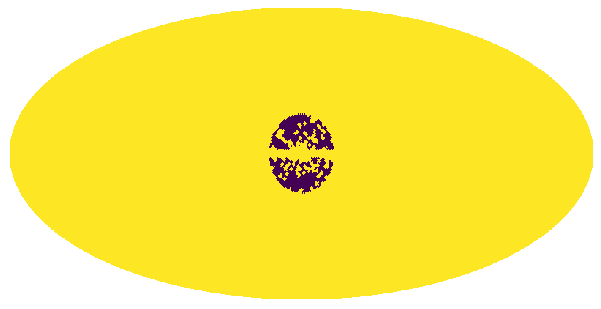

In [27]:
import sys
sys.path.append("../")

import utils.create_mask as cm

ps_mask = hp.ud_grade(np.load("../data/fermi_data/fermidata_pscmask.npy") > 0, nside_out=nside)
ps_mask = hp.ud_grade(np.load("../data/mask_3fgl_0p8deg.npy") > 0, nside_out=nside)

mask = cm.make_mask_total(nside=nside, band_mask = True, band_mask_range = 2,
                              mask_ring = True, inner = 0, outer = 20, 
                          custom_mask=ps_mask
                              )

hp.mollview(mask,title='',cbar=False,min=0,max=1)

In [28]:
fermi_counts = hp.ud_grade(np.load('../data/fermi_data/fermidata_counts.npy'), nside_out=nside, power=-2)
temp_bub = hp.ud_grade(np.load('../data/fermi_data/template_bub.npy'), nside_out=nside, power=-2)
temp_dsk = hp.ud_grade(np.load('../data//fermi_data/template_dsk.npy'), nside_out=nside, power=-2)
temp_psc = hp.ud_grade(np.load('../data/fermi_data/template_psc.npy'), nside_out=nside, power=-2)
temp_iso = hp.ud_grade(np.load('../data/fermi_data/template_iso.npy'), nside_out=nside, power=-2)
temp_dif = hp.ud_grade(np.load('../data/fermi_data/template_dif.npy'), nside_out=nside, power=-2)
mO_ics = hp.ud_grade(np.load("../data/fermi_data/ModelO_r25_q1_ics.npy"), nside_out=nside, power=-2)
mO_pibrem = hp.ud_grade(np.load("../data/fermi_data/ModelO_r25_q1_pibrem.npy"), nside_out=nside, power=-2)
mO_tot = mO_ics + mO_pibrem
temp_bub /= np.mean(temp_bub)
X = torch.tensor(np.radians(hp.pix2ang(nside, np.arange(hp.nside2npix(nside)), lonlat=True)))
Y = np.random.poisson(13. * mO_tot + 1. * temp_bub + 1. * 1. * temp_psc + 1. * temp_iso)

In [29]:
train_x = torch.tensor(X).float().T
train_y = torch.tensor(Y).float()

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [30]:
train_x = train_x[~mask]
train_y = train_y[~mask]

In [31]:
len(train_y)

895

../models/gp_regression.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


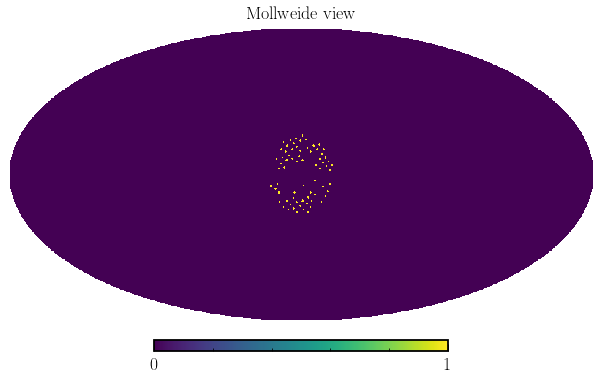

In [69]:
model = HealpixGPRegressionModel(temp_dif=temp_dif, temps=[temp_bub, temp_iso, temp_psc], 
                                             poiss_priors=[dist.Uniform(torch.tensor(0.02), torch.tensor(2.)),
                          dist.Uniform(torch.tensor(0.02), torch.tensor(2.)),
                          dist.Uniform(torch.tensor(0.02), torch.tensor(2.))],
                         temps_label=['bub','iso','psc'], mask=mask, name_prefix=randomString(8), 
                                 num_inducing=80, nside=nside)

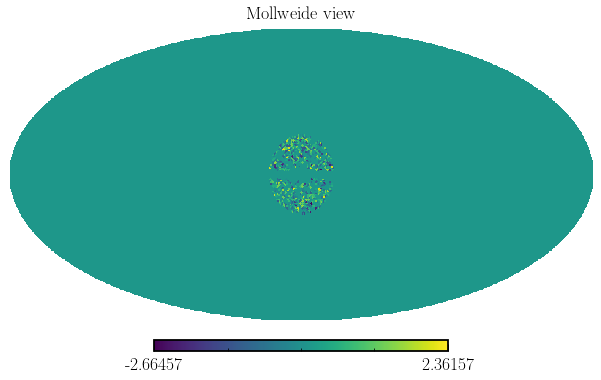

In [59]:
fwd = pyro.sample("blah", model.pyro_guide(train_x)).detach().numpy()
fwd_map = np.zeros(hp.nside2npix(nside))
fwd_map[~mask] = fwd
hp.mollview(fwd_map)

In [60]:
# plt.plot(np.exp(fwd))

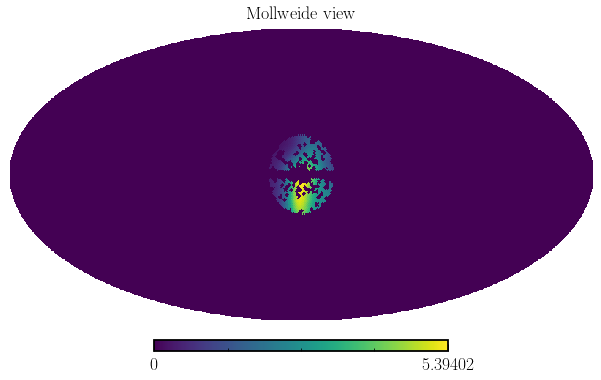

In [61]:
model.covar_module.base_kernel.lengthscale = 0.2
fwd = torch.exp(model.forward(train_x).sample())
fwd_map = np.zeros(hp.nside2npix(nside))
fwd_map[~mask] = fwd
hp.mollview(fwd_map)

In [62]:
# a_locs = pyro.param("a_scales", torch.full((3,), 1.0))
# a_locs
# from pyro.distributions.util import eye_like
# from torch.distributions import constraints
# pyro.param("a_scales", torch.full((3,3), 1.))

In [107]:
num_iter = 10000
num_particles = 16

optimizer = pyro.optim.Adam({"lr": 5e-3})

# elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True, )
elbo = pyro.infer.Trace_ELBO(retain_graph=True)
svi = pyro.infer.SVI(model=model.model, guide=model.guide, optim=optimizer, loss=elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter))
    
# pyro.clear_param_store()

for i in iterator:
    model.zero_grad() 
    loss = svi.step(train_x, train_y)
    iterator.set_postfix(loss=loss, lengthscale=model.covar_module.base_kernel.lengthscale.item())

In [ ]:
num_iter = 5000
num_particles = 64

optimizer = pyro.optim.Adam({"lr": 4e-4})

elbo = pyro.infer.Trace_ELBO(num_particles=num_particles, vectorize_particles=True, retain_graph=True, )
svi = pyro.infer.SVI(model=model.model, guide=model.guide, optim=optimizer, loss=elbo)

model.train()
iterator = tqdm.notebook.tqdm(range(num_iter))
    
for i in iterator:
    model.zero_grad() 
    loss = svi.step(train_x, train_y)
    iterator.set_postfix(loss=loss, lengthscale=model.covar_module.base_kernel.lengthscale.item())

In [100]:
# Here's a quick helper function for getting smoothed percentile values from samples
def percentiles_from_samples(samples, percentiles=[0.05, 0.5, 0.95]):
    num_samples = samples.size(0)
    samples = samples.sort(dim=0)[0]

    # Get samples corresponding to percentile
    percentile_samples = [samples[int(num_samples * percentile)] for percentile in percentiles]
    return percentile_samples

In [101]:
test_x = train_x

model.eval()
with torch.no_grad():
    output = model(test_x)

samples = output(torch.Size([100])).exp()
lower, median, upper = percentiles_from_samples(samples)

In [102]:
model.eval()
with torch.no_grad():
    predictive = Predictive(model.model, guide=model.guide, num_samples=1000)
    pred = predictive(train_x, train_y)
pred.keys()

dict_keys(['bub', 'iso', 'psc', 'xvnaogrd.u', 'xvnaogrd.f(x)', '.log_prior', '.added_loss', 'xvnaogrd.log_likelihood'])

In [103]:
mm = (mO_tot / temp_dif)[~mask]

In [104]:
lower, median, upper = np.percentile((pred['xvnaogrd.f(x)']).exp(), [5, 50, 95], axis=0)


In [105]:
# lower, median, upper = lower.detach().numpy(), median.detach().numpy(), upper.detach().numpy()

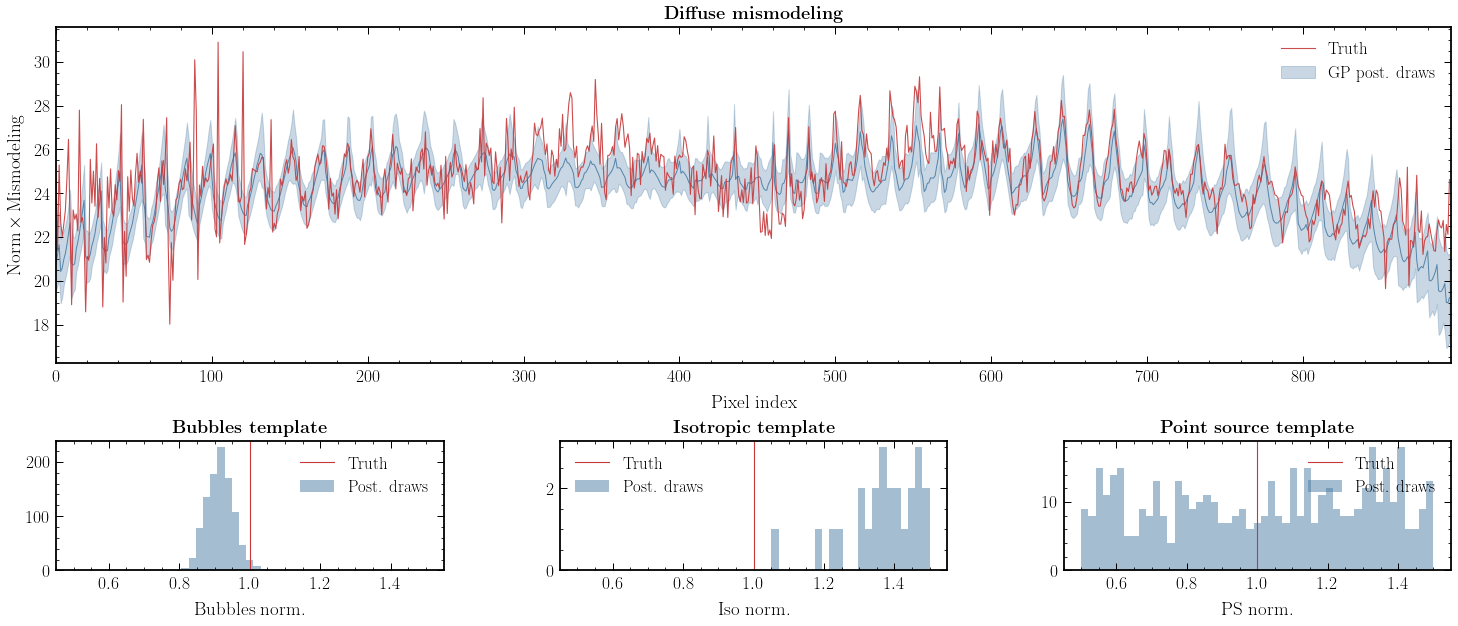

In [106]:
lw_truth = 1.1
fs_title = 18.

fig = plt.figure(constrained_layout=False, figsize=(25, 10))
ax = [None] * 4
gs = fig.add_gridspec(nrows=3, ncols=3, wspace=0.3, hspace=0.6)
ax[0] = fig.add_subplot(gs[:-1, :])
ax[1] = fig.add_subplot(gs[-1, 0])
ax[2] = fig.add_subplot(gs[-1, 1])
ax[3] = fig.add_subplot(gs[-1, 2])

ax[0].fill_between(np.arange(len(lower)), lower, upper, alpha=0.3, color=cols_default[1], label="GP post. draws")
ax[0].plot(median, color=cols_default[1], lw=1.)
ax[0].plot(13 * mm, color=cols_default[0], label="Truth", lw=lw_truth)

ax[0].set_xlabel("Pixel index")
ax[0].set_ylabel(r"Norm\,$\times$\,Mismodeling")
ax[0].set_title(r"\bf{Diffuse mismodeling}", fontsize=fs_title)
ax[0].legend()

ax[0].set_xlim(0, len(train_x))
# ax[0].set_ylim(0, 20)

ax[1].hist((pred['bub'].detach().numpy()), label="Post. draws", color=cols_default[1], alpha=0.5, bins=np.linspace(0.5, 1.5, 50));
ax[1].axvline(1., label="Truth", color=cols_default[0], lw=lw_truth)
ax[1].set_xlabel("Bubbles norm.")
ax[1].set_title(r"\bf{Bubbles template}", fontsize=fs_title)
ax[1].legend()

ax[2].hist((pred['iso'].detach().numpy()), label="Post. draws", color=cols_default[1], alpha=0.5, bins=np.linspace(0.5, 1.5, 50));
ax[2].axvline(1., label="Truth", color=cols_default[0], lw=lw_truth)
ax[2].set_xlabel("Iso norm.")
ax[2].set_title(r"\bf{Isotropic template}", fontsize=fs_title)
ax[2].legend()

ax[3].hist((pred['psc'].detach().numpy()), label="Post. draws", color=cols_default[1], alpha=0.5, bins=np.linspace(0.5, 1.5, 50));
ax[3].axvline(1., label="Truth", color=cols_default[0], lw=lw_truth)
ax[3].set_xlabel("PS norm.")
ax[3].set_title(r"\bf{Point source template}", fontsize=fs_title)
ax[3].legend()

In [584]:
from getdist import plots, MCSamples
import getdist


Removed no burn in


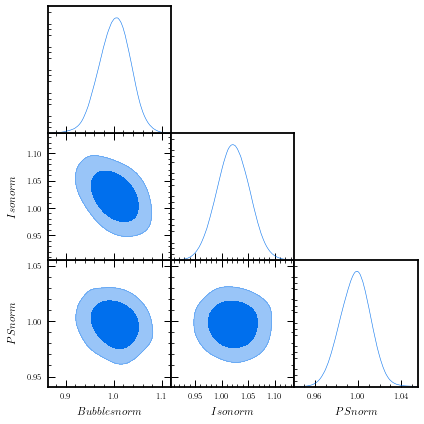

In [588]:
names = ["Bubbles norm", "Iso norm", "PS norm"]
labels = names
samples = pred['states'].detach().numpy()
samples = MCSamples(samples=samples, names=names, labels=labels)
g = plots.get_subplot_plotter()
g.triangle_plot([samples], filled=True)